In [1]:
# Setup
import numpy as np
import pandas as pd
import pyarrow as pa
import datetime

import pykx as kx
kx.q.system.console_size = [15, 100]

In [2]:
tab_BTC = kx.q.read.csv('data/BTCUSDT.csv')
# Create a new column in tab_BTC listing the date for each row
tab_BTC['date'] = tab_BTC['timestamp'].date

# Section 5: Time Series Analysis with PyKX

## Working with dates and times

#### Get current date / time

In [3]:
print(
      kx.DateAtom('today'),
      kx.TimeAtom('now'),
      kx.TimestampAtom('now')
      )

2024.08.21 11:36:30.151 2024.08.21D11:36:30.151942270


#### Generating date / time objects

In [4]:
# Generate a date object
kx.q('2020.01.01d')

pykx.DateAtom(pykx.q('2020.01.01'))

In [5]:
# Another way to generate a date object
kx.DateAtom(datetime.date(2020, 1, 1))

pykx.DateAtom(pykx.q('2020.01.01'))

In [6]:
# Generate random timestamps
timestamps = kx.random.random(3, kx.TimestampAtom('now'))
timestamps

pykx.TimestampVector(pykx.q('2009.09.04D13:38:51.608276288 2012.09.27D13:16:27.306237376 2012.09.17D13:12:38.052154560'))

In [7]:
# Extract the month from the timestamp
timestamps.month

pykx.IntVector(pykx.q('9 9 9i'))

#### Accessing Date / Time Attributes

In [8]:
# Extract the date from the timestamps
timestamps.date

pykx.DateVector(pykx.q('2009.09.04 2012.09.27 2012.09.17'))

In [9]:
# Extract the time from the timestamps
timestamps.time

pykx.TimeVector(pykx.q('13:38:51.608 13:16:27.306 13:12:38.052'))

In [10]:
# Extract the seconds from the timestamps
timestamps.second

pykx.IntVector(pykx.q('51 27 38i'))

In [11]:
# Convert timestamps in a table to dates
tab_BTC['timestamp'].date

pykx.DateVector(pykx.q('2017.08.17 2017.08.17 2017.08.17 2017.08.17 2017.08.17 2017.08.17 2017.08.17 2017.08.17 2017.08.1..'))

#### Plotting Time Series Data

In [12]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/pykx/wrappers.py:1918: UserWarning: Warning: Attempting to call numpy __array_function__ on a PyKX Vector type. __array_function__: <function atleast_1d at 0x79a8680d1990>. Support for this method is on a best effort basis.
  warnings.warn('Warning: Attempting to call numpy __array_function__ on a '


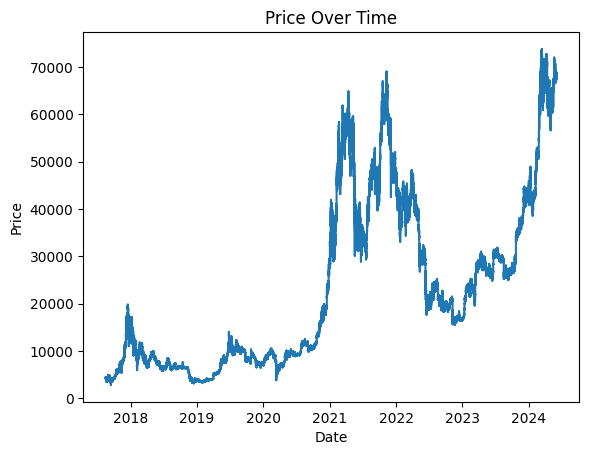

In [13]:
plt.plot(tab_BTC['date'],tab_BTC['close'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### Common Time Series Operations

###  xbar
The xbar operation floors numerical values to the nearest lower multiple of a specified step size. It can be useful in several scenarios when dealing with trade or quote market data such as to create price bins/bands/buckets to reduce noise and smooth a signal so it can be more easily understood for visualization, backtesting, and clustering.

In [14]:
# Apply the xbar operation to the 'close' column, flooring values to the nearest lower multiple of 10
tab_BTC.xbar({'close': 10})

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,date
,,,,,,,,,,,,,
0,2017.08.17D04:00:00.000000000,4261.48e,4261.48e,4261.48e,4260f,1.775183,2017.08.17D04:00:59.999000000,7564.907,3h,0.075183,320.3909,0b,2017.08.17
1,2017.08.17D04:01:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0f,2017.08.17D04:01:59.999000000,0f,0h,0f,0f,0b,2017.08.17
2,2017.08.17D04:02:00.000000000,4280.56e,4280.56e,4280.56e,4280f,0.261074,2017.08.17D04:02:59.999000000,1117.543,2h,0.261074,1117.543,0b,2017.08.17
3,2017.08.17D04:03:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0.012008,2017.08.17D04:03:59.999000000,51.17185,3h,0.012008,51.17185,0b,2017.08.17
4,2017.08.17D04:04:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0.140796,2017.08.17D04:04:59.999000000,599.9993,1h,0.140796,599.9993,0b,2017.08.17
5,2017.08.17D04:05:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0f,2017.08.17D04:05:59.999000000,0f,0h,0f,0f,0b,2017.08.17
6,2017.08.17D04:06:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0f,2017.08.17D04:06:59.999000000,0f,0h,0f,0f,0b,2017.08.17
7,2017.08.17D04:07:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0f,2017.08.17D04:07:59.999000000,0f,0h,0f,0f,0b,2017.08.17
8,2017.08.17D04:08:00.000000000,4261.48e,4261.48e,4261.48e,4260f,0f,2017.08.17D04:08:59.999000000,0f,0h,0f,0f,0b,2017.08.17


### Window Join
Window joins provide the ability to analyse the behaviour of data in one table in the neighborhood of another. To understand this concept, we will create two new tables, a trades table and quotes table.

In [15]:
# Setup
# Create a trades table
trades = kx.Table(data={
    'sym': ['ibm', 'ibm', 'ibm'],
    'time': kx.q('10:01:01 10:01:04 10:01:08'),
    'price': [100, 101, 105]})

# Create a quotes table
quotes = kx.Table(data={
    'sym': ['ibm'] * 9,  # Ensure 'sym' has the same number of entries as 'time'
    'time': kx.q('10:01:01+til 9'),
    'ask': [101, 103, 103, 104, 104, 107, 108, 107, 108],
    'bid': [98, 99, 102, 103, 103, 104, 106, 106, 107]
})

# Create a window, two seconds before and 1 second after each time in the trades table
windows = kx.q('{-2 1+\:x}', trades['time'])
windows

pykx.List(pykx.q('
10:00:59 10:01:02 10:01:06
10:01:02 10:01:05 10:01:09
'))

In [16]:
# Perform the window_join
trades.window_join(quotes,
                   windows,
                   ['sym', 'time'],
                   {'ask_minus_bid': [lambda x, y: x - y, 'ask', 'bid'],
                    'ask_max': [lambda x: max(x), 'ask']})

,sym,time,price,ask_minus_bid,ask_max
,,,,,
0,ibm,10:01:01,100,3 4,103
1,ibm,10:01:04,101,4 1 1 1,104
2,ibm,10:01:08,105,3 2 1 1,108
